<img src="https://i.ibb.co/TcVMz44/logo.jpg" alt="logo" border="0" width=200>

# Computational Astrophysics 2021
---
## Eduard Larrañaga

Observatorio Astronómico Nacional\
Facultad de Ciencias\
Universidad Nacional de Colombia

---

## Modelling an Exoplanet Transit Lightcurve
### About this notebook

In this worksheet we use the `astropy` package to read a .fits file from the exo.MAST database. We adjust a theoretical model to fit the observational data.

---

In this notebook we will use a .fits file from the exo.MAST database with the information of the lightcurve of the transit of an exoplanet. Go to the page 

[https://exo.mast.stsci.edu](https://exo.mast.stsci.edu)

Click on the `View Table of Exoplanets` link and search for the object **HAT-P-7_b**. 

Click on the `Kepler Light Curve` link (Top right of the page) and download the data file. 



Now, we will use the `astropy` package to read the .fits file. For a detalied description of working with .fits files using `astropy`, go to

http://docs.astropy.org/en/stable/io/fits/index.html


---

### Read the .fits file


In [30]:
from matplotlib import pyplot as plt
from astropy.io import fits
import numpy as np
from numpy import pi, sqrt, sin, mean
%matplotlib inline

In [2]:
hdul = fits.open('kplr010666592-20160128150956_dvt.fits')
lc_data = hdul[1].data
hdul.close()

We extract the .FITS_rec information into a table using the `astropy.table.Table` function

In [3]:
from astropy.table import Table 

binarytable = Table(lc_data)
binarytable

TIME,TIMECORR,CADENCENO,PHASE,LC_INIT,LC_INIT_ERR,LC_WHITE,LC_DETREND,MODEL_INIT,MODEL_WHITE
float64,float32,int32,float32,float32,float32,float32,float32,float32,float32
131.51205364935595,-0.0010598294,1105,1.3335272,-3.954151e-05,2.5503115e-05,-0.34372607,-3.954151e-05,0.0,0.10576324
131.53248808165517,-0.0010605616,1106,1.3539616,-2.2603195e-05,2.5496436e-05,0.029184762,-2.2603195e-05,0.0,0.20860007
131.5529224139318,-0.0010612939,1107,1.374396,-3.5658915e-05,2.5480678e-05,-0.11320674,-3.5658915e-05,0.0,0.30092743
131.57335664615675,-0.0010620261,1108,1.3948301,-3.3626442e-05,2.5509618e-05,-0.043413952,-3.3626442e-05,0.0,0.37470224
131.59379097835335,-0.0010627584,1109,1.4152645,7.243876e-05,2.5514733e-05,1.6507578,7.243876e-05,0.0,0.42141774
131.6142254105216,-0.0010634905,1110,1.4356989,-1.9167643e-05,2.551281e-05,0.19305673,-1.9167643e-05,0.0,0.43312293
...,...,...,...,...,...,...,...,...,...
1590.8786588268922,-0.00010830689,72525,1.167983,-1.6757078e-05,2.5910123e-05,-0.2840508,-1.6757078e-05,0.0,0.2229695
1590.8990932329907,-0.00010901299,72526,1.1884174,-1.3110765e-05,2.59211e-05,-0.11579718,-1.3110765e-05,0.0,0.2549398


### Visualizing the Image

We will use the `matplotlib.pyplot` package to visualize the light-curve data. First we will extract the relevant features:

**'TIME'**: : [float] The Barycentric Julian date of each cadence minus the offset 2454833. This value is available for all cadences in the file, even if no data is available at those times.

**'LC INIT'** : [float] The initial light curve discussed in the introduction. This light curve has been quarter-stitched, harmonic-removed and has a mean of zero

**LC WHITE** : [float] The whitened light curve that was searched by TPS to find this TCE. This is LC INIT after the whitening filter is applied.
 
**MODEL INIT** : [float] The transit model calculated for the initial light curve.
 
**MODEL WHITE** : [float] The whitened transit model calculated for the whitened light curve.


---

We will NOT calibrate the time in this notebook!! However, you can see this guide for a detailed description:

https://spacetelescope.github.io/notebooks/notebooks/MAST/Kepler/Kepler_Lightcurve/kepler_lightcurve.html

or the Kepler manual

https://archive.stsci.edu/kepler/manuals/archive_manual.pdf


In [4]:
time = binarytable['TIME']
lc_init = binarytable['LC_INIT']
lc_model = binarytable['MODEL_INIT']
len(lc_init)

71427

We will restrict to the first 200 days to plot the transit. Note that there is one transit in each 100 points interval.

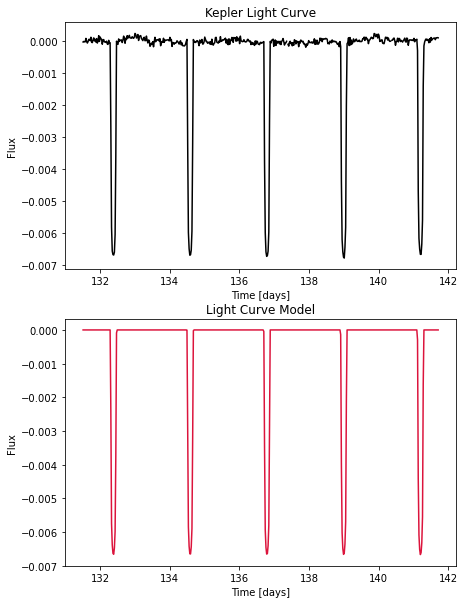

In [6]:
fig,ax = plt.subplots(2,1,figsize=(7,10))

# Plot the time, uncorrected and corrected fluxes.
ax[0].plot(time[0:500], lc_init[0:500], '-k') 
ax[0].set_title('Kepler Light Curve')
ax[0].set_xlabel('Time [days]')
ax[0].set_ylabel('Flux')

ax[1].plot(time[0:500], lc_model[0:500], color='crimson') 
ax[1].set_title('Light Curve Model')

ax[1].set_xlabel('Time [days]')
ax[1].set_ylabel('Flux')
plt.show()

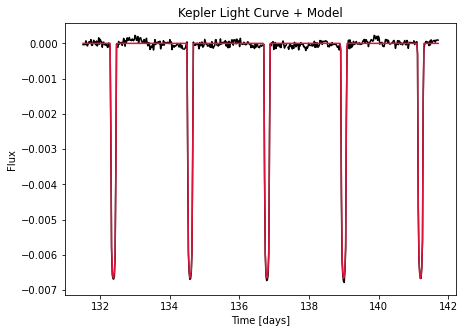

In [7]:
plt.figure(figsize=(7,5))
plt.plot(time[0:500], lc_init[0:500], color='black') 
plt.plot(time[0:500], lc_model[0:500], color='crimson') 
plt.title('Kepler Light Curve + Model')
plt.xlabel('Time [days]')
plt.ylabel('Flux')
plt.show()

---
## Physical Properties of the Exoplanet-Star System

The objective now is to find the physical properties of the system, from the observational points. All the resuklts are based on the paper by [[S. Seager and G. Mallén-Ornelas, 2002]](https://arxiv.org/abs/astro-ph/0206228v1)

|Parameter | value|
|---|---|
|Radius ratio | $\frac{R_p}{R_*}$  |
|Impact parameter| $b$|
|Linear limb darkening parameter| $\gamma_1$|
|Quadratic limb darkening parameter| $\gamma_2$|
|Semi-major axis|$\frac{a}{R_*}$|
|Orbital period|T|
|Orbital phase|$\delta$|

The planet is not moving on the equatorial plane of the star (as seen by the observer), and therefore, we have included the impact parameter $b$ and define the coordinate describing the motion as

\begin{equation}
z = \sqrt{x^2 + b^2},
\end{equation}

where $x$ represents the the equatorial plane coordinate depending on time as

\begin{equation}
x(t) =  a \cos \left[ \omega (t - \delta) + \frac{\pi}{2} \right]
\end{equation}

and 

\begin{equation}
\omega = \frac{2\pi}{T}.
\end{equation}

**In practice, this definition will give twice the transits becuase the motion of the exoplanet behind he star will be conisdered also as a transit!**.


### Finding the Period of the Motion

Consider the first two transits to illustrate how to obtain the period:

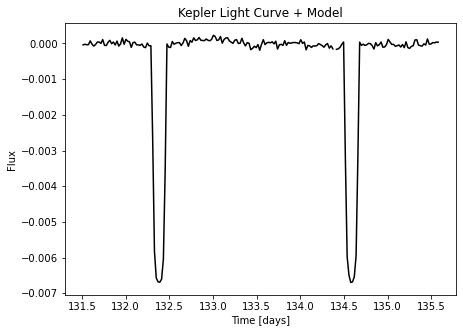

In [8]:
time_slice = time[0:200]
lc_slice = lc_init[0:200]
plt.figure(figsize=(7,5))
plt.plot(time_slice, lc_slice, color='black') 
plt.title('Kepler Light Curve + Model')
plt.xlabel('Time [days]')
plt.ylabel('Flux')
plt.show()

Using the function `numpy.nanmin()`, we find each of the minima (This function doesn't considers the nan entries)

In [9]:
np.nanmin(lc_slice[0:100])

-0.0066898437

In [10]:
np.nanmin(lc_slice[100:200]) 

-0.0066959118

Now, we use `numpy.where()` to find the index of these points, 

In [11]:
min1_idx = np.where(lc_slice == np.nanmin(lc_slice[0:100]))[0][0]
min1_idx

43

In [12]:
min2_idx = np.where(lc_slice == np.nanmin(lc_slice[100:200]))[0][0]
min2_idx

150

The period corresponds to the time difference between these two points,

In [13]:
Period = time_slice[min2_idx] - time_slice[min1_idx]
Period

2.186472837878682

To obtain a better value for the period, we implement a loop to calculate this time interval between each pair of transits. Then we take the arithmetic mean of the obtained values.

In [17]:
import warnings
warnings.filterwarnings('ignore')

Period_values = []
N = 0 # Counts the number of transits
transit_idx = [] # List with the indices of the transit points

for i in range(1,700):
    min1 = np.nanmin(lc_init[100*(i-1):100*i])
    min2 = np.nanmin(lc_init[100*(i):100*(i+1)])
    # We need to get rid of possible measurement errors
    if abs(min1)>0.001 and abs(min2)>0.001:
        P = time[np.where(lc_init == min2)[0][0]] - time[np.where(lc_init == min1)[0][0]]
        if P>1.:
            transit_idx.append(np.where(lc_init == min1)[0][0])
            Period_values.append(P)
            N += 1

Period = mean(Period_values)

print(f'\nWe obtain {N:.0f} period values and the mean value is T = {Period:.3f} days.\n')            



We obtain 558 period values and the mean value is T = 2.204 days.



### Finding the Phase of the Signal

We will define the phase of the observed signal, $\delta$, as the time of the first transit:

In [18]:
delta = time[transit_idx[0]]
print(f'\nThe fase of the signal is delta = {delta:.4f}\n')


The fase of the signal is delta = 132.3907



### Finding the Transit Depth

The transit depth $\Delta F$ is defined in [[S. Seager and G. Mallén-Ornelas, 2002]](https://arxiv.org/abs/astro-ph/0206228v1) as 

\begin{equation}
\Delta F = \frac{F_{\text{no transit}}- F_{\text{transit}}}{F_{\text{no transit}}}
\end{equation}

For this dataset, we normalize the 'no-transit' flux to one and then,  $\Delta F$ is just the depth at each transit. Since we already have the indices identifying each transit, we take an arithmetic mean of the flux depth values:

In [19]:
flux_sum = []
for i in transit_idx:
    flux_sum.append(abs(lc_init[i]))
        
DeltaF = mean(flux_sum)
DeltaF

0.006641408

According to [[S. Seager and G. Mallén-Ornelas, 2002]](https://arxiv.org/abs/astro-ph/0206228v1), the flux depth and the ratio of the radius of planet and star are related by

\begin{equation}
\Delta F = \left(\frac{R_p}{R_*} \right)^2 = p^2
\end{equation}

Therefore, we obtain

In [21]:
p = sqrt(DeltaF)
print(f'The ratio of planet radius to star radius is p = {p:.3f}')

The ratio of planet radius to star radius is p = 0.081


## Total Transit Duration and Duration of the Transit Completely Inside

Following the definitions of [[S. Seager and G. Mallén-Ornelas, 2002]](https://arxiv.org/abs/astro-ph/0206228v1), we will calculate

- $t_T$ : The total transit duration (first to fourth contact)
- $t_f$ : The duration  of the transit completely inside ingress and egress (second to third contact) 

Look at the first transit in the data set:

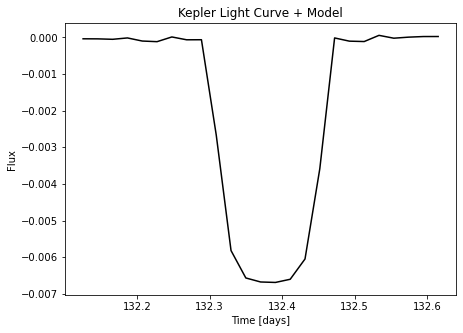

In [22]:
time_slice = time[30:55]
lc_slice = lc_init[30:55]
plt.figure(figsize=(7,5))
plt.plot(time_slice, lc_slice, color='black') 
plt.title('Kepler Light Curve + Model')
plt.xlabel('Time [days]')
plt.ylabel('Flux')
plt.show()

We find $t_f$ beginning at the minimum and looking for the boundary of bottom flat part of the curve.

In [23]:
j = 0
# Find the in time
while abs(lc_init[transit_idx[0]-j] - lc_init[transit_idx[0]])< 0.0005:
    j+=1
t_f_in = time[transit_idx[0]-j]

k = 0
# Find the out time
while abs(lc_init[transit_idx[0]+k] - lc_init[transit_idx[0]])< 0.0005:
    k+=1
t_f_out = time[transit_idx[0]+k]

t_f = t_f_out - t_f_in
t_f

0.10217155349528184

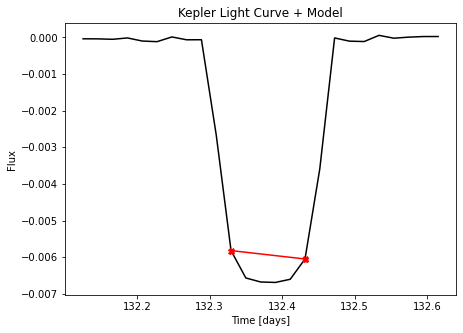

In [24]:
time_slice = time[30:55]
lc_slice = lc_init[30:55]
plt.figure(figsize=(7,5))
plt.plot(time_slice, lc_slice, color='black') 
plt.plot([time[transit_idx[0]-j],time[transit_idx[0]+k]], [lc_init[transit_idx[0]-j],lc_init[transit_idx[0]+k]],'r', marker='X')
plt.title('Kepler Light Curve + Model')
plt.xlabel('Time [days]')
plt.ylabel('Flux')
plt.show()

Now, we do the same for all transit points and take the average,

In [25]:
t_f_values = []
for i in range(N):
    j = 0
    # Find the in time
    while abs(lc_init[transit_idx[i]-j] - lc_init[transit_idx[i]])< 0.0005:
        j+=1
    t_f_in = time[transit_idx[i]-j]

    # Find the out time
    j = 0
    while abs(lc_init[transit_idx[i]+j] - lc_init[transit_idx[i]])< 0.0005:
        j+=1
    t_f_out = time[transit_idx[i]+j]
    
    t_f_values.append(t_f_out - t_f_in)

t_f = mean(t_f_values)
print(f'The mean value of t_f is {t_f:.4f}')

The mean value of t_f is 0.1024


Similarly, we can find the value of the time $t_T$ by looking for the boundary of the upper flat part, beginning at each transit point.

In [26]:
j = 0
# Find the in time
while abs(lc_init[transit_idx[0]-j] - lc_init[transit_idx[0]])< abs(lc_init[transit_idx[0]]*0.9):
    j+=1
t_T_in = time[transit_idx[0]-j]

k = 0
# Find the out time
while abs(lc_init[transit_idx[0]+k] - lc_init[transit_idx[0]])< abs(lc_init[transit_idx[0]]*0.9):
    k+=1
t_T_out = time[transit_idx[0]+k]

t_T = t_T_out - t_T_in
t_T

0.18390907631692244

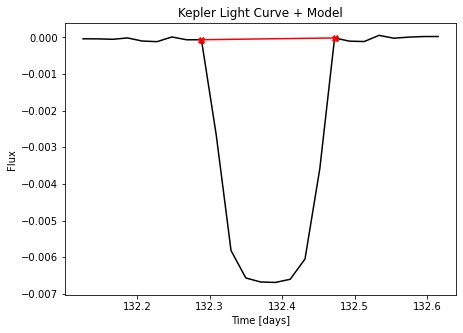

In [27]:
time_slice = time[30:55]
lc_slice = lc_init[30:55]
plt.figure(figsize=(7,5))
plt.plot(time_slice, lc_slice, color='black') 
plt.plot([time[transit_idx[0]-j],time[transit_idx[0]+k]], [lc_init[transit_idx[0]-j],lc_init[transit_idx[0]+k]],'r', marker='X')
plt.title('Kepler Light Curve + Model')
plt.xlabel('Time [days]')
plt.ylabel('Flux')
plt.show()

In [28]:
t_T_values = []
for i in range(N):
    j = 0
    # Find the in_time
    while abs(lc_init[transit_idx[0]-j] - lc_init[transit_idx[0]])< abs(lc_init[transit_idx[0]]*0.9):
        j+=1
    t_T_in = time[transit_idx[i]-j]

    # Find the out_time
    j = 0
    while abs(lc_init[transit_idx[0]+j] - lc_init[transit_idx[0]])< abs(lc_init[transit_idx[0]]*0.9):
        j+=1
    t_T_out = time[transit_idx[i]+j]

    t_T_values.append(t_T_out - t_T_in)

t_T = mean(t_T_values)
print(f'The mean value of t_T is {t_T:.4f}')

The mean value of t_T is 0.1839


## The impact parameter and the semi-amjor axis

We use equations (7) and (8) of  [[S. Seager and G. Mallén-Ornelas, 2002]](https://arxiv.org/abs/astro-ph/0206228v1) to estimate the values of the impact parameter $b$ and the semi-major axis $a$,

In [31]:
sin2_tF = (sin(t_f*pi/Period))**2
sin2_tT = (sin(t_T*pi/Period))**2
sin2_ratio = sin2_tF/sin2_tT

b = sqrt(((1-p)**2 - sin2_ratio*(1+p)**2 )/(1 - sin2_ratio))
b

0.8329481379172833

In [32]:
a = sqrt((1 + p)**2 - (b**2)*(1 - sin2_tT))/sqrt(sin2_tT)
a

2.789476885770167

---
### Comparison of Results


|Parameter | value | obtained | reported in database |
|---|---|---|---|
|Radius ratio | $\frac{R_p}{R_*}$  | 0.081 |0.078|
|Impact parameter| $b$| 0.8329 | 0.5 |
|Linear limb darkening parameter| $\gamma_1$| NA | NR |
|Quadratic limb darkening parameter| $\gamma_2$| NA | NR |
|Semi-major axis|$\frac{a}{R_*}$| 2.7894 | 3.952 ( a =0.037 au = 7.956 $R_{\odot}$)|
|Orbital period|T| 2.204 days | 2.20474 days |
|Orbital phase|$\delta$| 132.3907 days | NR |

In [33]:
# Parameters for the model
p = 0.081 #radius ratio
b = 0.832 #impact parameter
gamma1 = 0.3 #linear limb darkening 
gamma2 = 0.3 #quadratic limb darkening
a = 2.789  #normalized semi-major axis (normalized with the star radius)
T = 2.204 #orbital period
delta = 132.3907 #orbital phase
omega = 2*np.pi/T #angular velocity

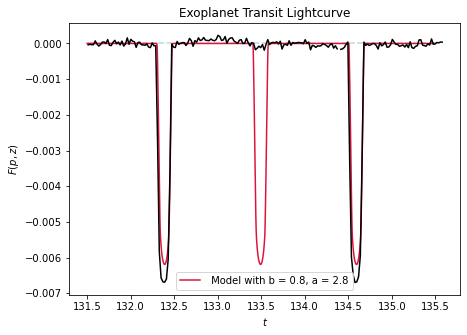

tiempo de cómputo: -1.987500013456156e-05


In [37]:
from scipy.misc import derivative
import scipy.integrate as integrate
import numpy as np
import matplotlib.pyplot as plt
import timeit

def L(r, P, Z): #it is already multiplied by r² as it is in the derivate into the integral
  '''
  Obstruction function
  '''
  p = P/r
  z0 = Z/r
  
  # Reflects the information w.r.t. the y axis  
  if z0>0:
    z = z0
  if z0<0:
    z = -z0
    
  if z>1+p:
    return 0.
  elif (abs(1-p)<z and z<=1+p):
    k0 = np.arccos((p**2 + z**2 -1)/(2*p*z))
    k1 = np.arccos((1-p**2 + z**2)/(2*z))
    L0 = k0*p**2
    L2 = np.sqrt((4*z**2- (1+z**2-p**2)**2)/4) 
    return (L0 + k1 - L2)*r**2/np.pi
  elif (z<=1-p):
    return p**2*r**2
  elif z<= p-1: 
    return 1.*r**2


def I_function(r):
  '''
  Quadratic limb-darkening function
  '''
  mu = np.sqrt(1-r**2) 
  return 1. - gamma1*(1-mu) - gamma2*(1-mu)**2


def integrand_1(r, p, z):
  '''
  Integrand in the numerator
  '''
  T1 = derivative(L, r, dx=1e-6, args=(p,z))
  T2 = I_function(r)
  return T1*T2


def integrand_2(r):
  '''
  Integrand in the denominator
  '''
  return I_function(r)*2*r





# Grid definition
N = 1000
t = np.linspace(131.5,135.5,N)
x = a*np.cos(omega*(t-delta)+np.pi/2)

z_range = np.sqrt(x**2 + b**2)


# Flux
F = np.zeros(N)


# Main Loop to calculate the Flux

for i in range(N):
    Integral_1 = integrate.quad(integrand_1, 0.0001, 1., args=(p,z_range[i]))[0]
    Integral_2 = integrate.quad(integrand_2, 0.0001, 1.)[0]
    F[i] = 0. - Integral_1/Integral_2


start = timeit.timeit()
# Plot the Flux as function of time
plt.figure(figsize=(7,5))
plt.plot(t, F,color='crimson', label=f' Model with b = {b:.1f}, a = {a:.1f}')
plt.hlines(0., t[0], t[-1],linestyle='dashed', alpha=0.3)
plt.plot(time[0:200], lc_init[0:200], color='black') 
plt.xlabel(r'$t$')
plt.ylabel(r'$F(p,z)$')
plt.title('Exoplanet Transit Lightcurve')
plt.legend()
plt.show()

end = timeit.timeit()
print(f'tiempo de cómputo: {end - start}')